In [3]:
import pandas as pd
import numpy as np
import io
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

In [4]:
from google.colab import files
data = files.upload()

Saving S4248SM144NCEN.csv to S4248SM144NCEN.csv


In [5]:
df = pd.read_csv("S4248SM144NCEN.csv",index_col='DATE',parse_dates=True)

In [6]:
df.head()

,S4248SM144NCEN
DATE,
1992-01-01,3459
1992-02-01,3458
1992-03-01,4002
1992-04-01,4564
1992-05-01,4221


In [7]:
df.rename(columns={"S4248SM144NCEN":"nondurable goods sales"},inplace=True)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 370 entries, 1992-01-01 to 2022-10-01
Data columns (total 1 columns):
 #   Column                  Non-Null Count  Dtype
---  ------                  --------------  -----
 0   nondurable goods sales  370 non-null    int64
dtypes: int64(1)
memory usage: 5.8 KB


In [9]:
df.describe()

,nondurable goods sales
count,370.000000
mean,8678.018919
std,3550.443776
min,3031.000000
25%,5525.500000
50%,8374.000000
75%,11232.000000
max,18139.000000


In [10]:
df.isnull().sum()

nondurable goods sales    0
dtype: int64

Text(0, 0.5, 'Sales (millions of dollars)')

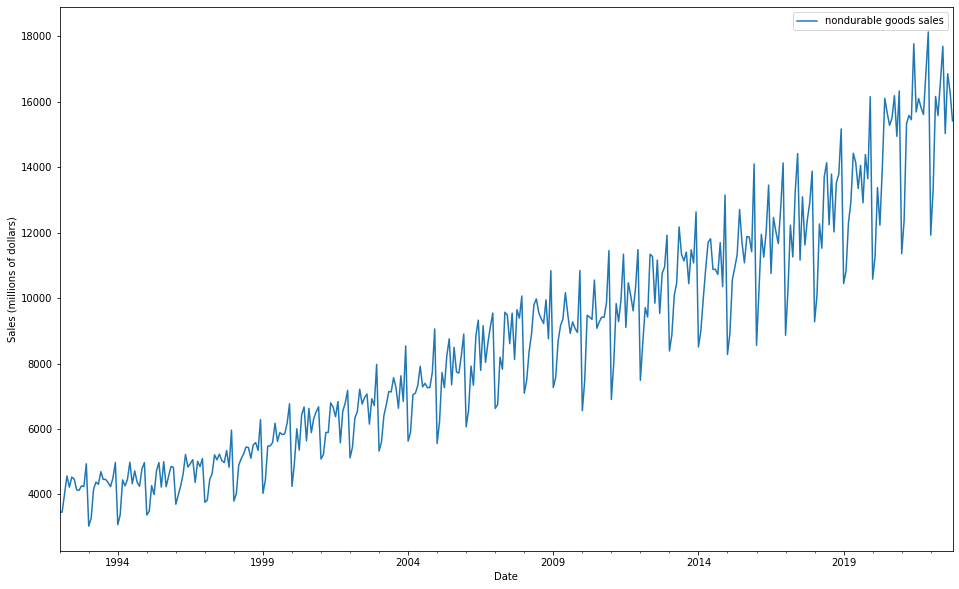

In [11]:
df.plot(figsize=(16,10))
plt.xlabel('Date')
plt.ylabel('Sales (millions of dollars)')

# Train/test split 

In [12]:
len(df)

370

In [13]:
len(df)-12

358

In [14]:
test_size= 12

In [15]:
test_ind= len(df)- test_size

In [16]:
train= df.iloc[:test_ind]
test= df.iloc[test_ind:]

# Scaling our data

In [17]:
from sklearn.preprocessing import MinMaxScaler

In [18]:
scaler = MinMaxScaler()

In [19]:
scaler.fit(train)

MinMaxScaler()

In [20]:
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

# Time series generator

In [21]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [22]:
length = 12
generator = TimeseriesGenerator(scaled_train, scaled_train, length=length, batch_size=1)

## Creating model RNN with LSTM

In [23]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,LSTM

In [24]:
n_features = 1

In [25]:
model = Sequential()
model.add(LSTM(100, activation='relu',input_shape=(length,n_features)))
model.add(Dense(1))
model.compile(optimizer='adam',loss='mse')
    


In [26]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100)               40800     
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [198]:
validation_generator = TimeseriesGenerator(scaled_test,scaled_test,length=11,batch_size=1)

In [27]:
model.fit(generator,epochs=50)

Epoch 1/50
346/346 [==============================] - 4s 7ms/step - loss: 0.0130
Epoch 2/50
346/346 [==============================] - 3s 8ms/step - loss: 0.0078
Epoch 3/50
346/346 [==============================] - 3s 8ms/step - loss: 0.0072
Epoch 4/50
346/346 [==============================] - 3s 8ms/step - loss: 0.0072
Epoch 5/50
346/346 [==============================] - 3s 7ms/step - loss: 0.0061
Epoch 6/50
346/346 [==============================] - 3s 7ms/step - loss: 0.0057
Epoch 7/50
346/346 [==============================] - 3s 8ms/step - loss: 0.0047
Epoch 8/50
346/346 [==============================] - 4s 12ms/step - loss: 0.0045
Epoch 9/50
346/346 [==============================] - 3s 10ms/step - loss: 0.0041
Epoch 10/50
346/346 [==============================] - 3s 8ms/step - loss: 0.0030
Epoch 11/50
346/346 [==============================] - 3s 8ms/step - loss: 0.0024
Epoch 12/50
346/346 [==============================] - 3s 8ms/step - loss: 0.0022
Epoch 13/50
346/346 [==

In [28]:
losses = pd.DataFrame(model.history.history)

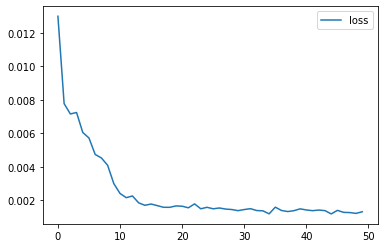

In [29]:
losses.plot()

LSTM Predictions

In [30]:
test_predictions = []
first_eval_batch = scaled_train[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(len(test)):
  current_pred = model.predict(current_batch)[0]
  test_predictions.append(current_pred)
  current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

1/1 [==============================] - 0s 23ms/step


In [31]:
true_predictions = scaler.inverse_transform(test_predictions)

In [32]:
test['Predictions'] = true_predictions

<ipython-input-32-920b79c3c314>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['Predictions'] = true_predictions


In [33]:
test

,nondurable goods sales,Predictions
DATE,,
2021-11-01,16896,15826.003470
2021-12-01,18139,16768.444417
2022-01-01,11926,12425.506783
2022-02-01,13333,13607.950562
2022-03-01,16165,15804.994950
2022-04-01,15584,16177.878605
2022-05-01,16600,16414.517999
2022-06-01,17700,18130.459014
2022-07-01,15031,16563.702748


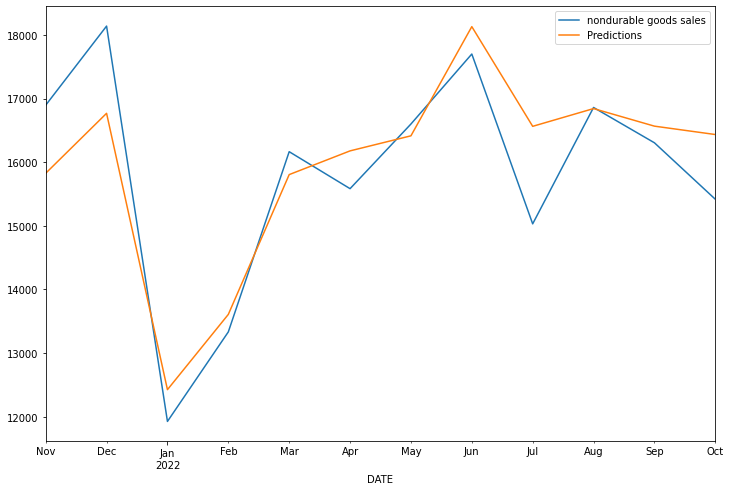

In [34]:
test.plot(figsize=(12,8))